In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from PIL import Image
import random


# Keras 3 imports
import keras
from keras import layers, models, optimizers, callbacks
from keras.utils import to_categorical
import keras.ops as ops



random.seed(42)
np.random.seed(42)
keras.utils.set_random_seed(42)


In [22]:
# Configuration
IMAGE_SIZE = 224  # Changed from 64 to 224
NUM_CLASSES = 6
BATCH_SIZE = 8
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 50
DATASET_PATH = r"/content/drive/MyDrive/concave"

In [24]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False


    def __call__(self, val_loss):
        print(f"val_loss, best_loss: {val_loss}, {self.best_loss}")
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True


In [25]:
def load_image_dataset(dataset_path, image_size=IMAGE_SIZE):


    images = []
    labels = []
    class_names = []

    if not os.path.exists(dataset_path):
        print(f"Dataset path {dataset_path} does not exist!")
        return np.array([]), np.array([]), []

    # Get class directories
    class_dirs = [d for d in os.listdir(dataset_path)
                  if os.path.isdir(os.path.join(dataset_path, d))]
    class_dirs.sort()
    class_names = class_dirs[:NUM_CLASSES]  # Limit to NUM_CLASSES

    print(f"Found {len(class_names)} classes: {class_names}")

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

        print(f"Loading {len(image_files)} images from class '{class_name}'")

        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            try:
                # Load and preprocess image
                image = Image.open(image_path)
                if image.mode != 'RGB':
                    image = image.convert('RGB')
                image = image.resize((image_size, image_size))
                image_array = np.array(image) / 255.0  # Normalize to [0,1]

                images.append(image_array)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {image_path}: {e}")

    return np.array(images), np.array(labels), class_names

In [26]:
# Data augmentation layer
def create_augmentation_layer():
    return keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ])


In [38]:
def mbconv_block(x, in_channels, out_channels, expansion_factor=4, stride=1):
    """Mobile Inverted Bottleneck Convolution block"""
    input_tensor = x
    expanded_channels = in_channels * expansion_factor

    # Expansion phase
    if expansion_factor != 1:
        x = layers.Conv2D(expanded_channels, 1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('gelu')(x)

    # Depthwise convolution
    x = layers.DepthwiseConv2D(3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)

    # Squeeze and Excitation
    x = eca_block(x, expanded_channels)

    # Projection phase
    x = layers.Conv2D(out_channels, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Residual connection
    if stride == 1 and in_channels == out_channels:
        x = layers.Add()([input_tensor, x])

    return x

In [39]:
# CoAtNet-inspired model using Keras layers
def create_coatnet_model(num_classes, image_size, dropout_rate=0.3):
    inputs = layers.Input(shape=(image_size, image_size, 3))

    # Data augmentation (only during training)
    augmentation = create_augmentation_layer()

    # Stem (Initial convolution)
    x = layers.Conv2D(64, 3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x)

    # Stage 1: MBConv-like blocks
    x = mbconv_block(x, 64, 64, expansion_factor=4)
    x = mbconv_block(x, 64, 64, expansion_factor=4)

    # Stage 2: MBConv-like blocks with stride
    x = mbconv_block(x, 64, 128, expansion_factor=4, stride=2)
    x = mbconv_block(x, 128, 128, expansion_factor=4)

    # Stage 3: Transformer-like blocks
    x = transformer_block(x, 128, 256, num_heads=8)
    x = transformer_block(x, 256, 256, num_heads=8)

    # Stage 4: Final transformer blocks
    x = transformer_block(x, 256, 512, num_heads=8, stride=2)
    x = transformer_block(x, 512, 512, num_heads=8)

    # Global Average Pooling and Classification Head
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [40]:
def eca_block(x, channels, k_size=3):
    """Efficient Channel Attention block"""
    # Global Average Pooling - same as SE block
    eca = layers.GlobalAveragePooling2D()(x)

    # Reshape to (batch, channels, 1) for 1D convolution
    eca = layers.Reshape((channels, 1))(eca)

    # 1D convolution with adaptive or fixed kernel size
    eca = layers.Conv1D(
        filters=1,
        kernel_size=k_size,
        padding='same',
        use_bias=False,
        activation=None
    )(eca)

    # Reshape back to (batch, 1, 1, channels) for broadcasting
    eca = layers.Reshape((1, 1, channels))(eca)

    # Sigmoid activation
    eca = layers.Activation('sigmoid')(eca)

    # Element-wise multiplication
    return layers.Multiply()([x, eca])


In [41]:
import math

def adaptive_kernel_size(channels, gamma=2, b=1):
    """Calculate adaptive kernel size based on channel count"""
    t = int(abs(math.log(channels, 2) + b) / gamma)
    k = t if t % 2 else t + 1  # Ensure odd kernel size
    return max(k, 3)  # Minimum kernel size of 3

def eca_block_adaptive(x, channels):
    """ECA block with adaptive kernel size"""
    k_size = adaptive_kernel_size(channels)
    return eca_block(x, channels, k_size)



In [42]:
def transformer_block(x, in_channels, out_channels, num_heads=8, stride=1):
    """Fixed transformer block using multi-head attention"""
    input_tensor = x

    # Handle channel dimension changes first
    if in_channels != out_channels:
        input_tensor = layers.Conv2D(out_channels, 1, use_bias=False)(input_tensor)
        input_tensor = layers.BatchNormalization()(input_tensor)
        x = layers.Conv2D(out_channels, 1, use_bias=False)(x)
        x = layers.BatchNormalization()(x)

    # Handle spatial dimension changes (stride)
    if stride > 1:
        x = layers.MaxPooling2D(stride)(x)
        input_tensor = layers.MaxPooling2D(stride)(input_tensor)

    # Multi-head attention (approximated with convolutions)
    attn = layers.LayerNormalization()(x)
    attn = layers.Conv2D(out_channels, 1)(attn)
    attn = layers.Activation('gelu')(attn)
    attn = layers.Conv2D(out_channels, 1)(attn)
    x = layers.Add()([x, attn])

    # Feed forward network
    ff = layers.LayerNormalization()(x)
    ff = layers.Conv2D(out_channels * 4, 1)(ff)
    ff = layers.Activation('gelu')(ff)
    ff = layers.Conv2D(out_channels, 1)(ff)

    # Final residual connection (now shapes should match)
    x = layers.Add()([x, ff])

    # Add the input_tensor residual connection
    x = layers.Add()([input_tensor, x])

    return x

In [43]:
def train_model(model, train_data, val_data, class_names):
    """Train the model with early stopping"""

    # Compile model
    model.compile(
        optimizer=optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary
    model.summary()

    # Callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=45,
        restore_best_weights=True
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7
    )

    model_checkpoint = callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True
    )

    # Train model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )

    return history

In [44]:

def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()



In [45]:
def evaluate_model(model, test_data, class_names):
    """Evaluate model and create confusion matrix"""

    # Get predictions
    y_pred = model.predict(test_data)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get true labels
    y_true = []
    for _, labels in test_data:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    return accuracy, cm


Loading dataset...
Found 900 files belonging to 6 classes.
Using 720 files for training.
Found 900 files belonging to 6 classes.
Using 180 files for validation.
Found 6 classes: ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']
Creating model...
Starting training...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 224, 224,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 224, 224,  │     36,928 │ activation_27[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 224, 224,  │     16,384 │ conv2d_51[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │      1,024 │ conv2d_52[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_8  │ (None, 224, 224,  │      2,304 │ activation_28[0]… │
│ (DepthwiseConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │      1,024 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ activation_29[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 256, 1)    │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 1)    │          3 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1, 1, 256) │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 1, 1, 256) │          0 │ reshape_5[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 224, 224,  │          0 │ activation_29[0]… │
│ (Multiply)          │ 256)              │            │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 224, 224,  │     16,384 │ multiply_4[0][0]

 Total params: 7,216,466 (27.53 MB)

 Trainable params: 7,207,378 (27.49 MB)

 Non-trainable params: 9,088 (35.50 KB)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.2457 - loss: 2.4806 - val_accuracy: 0.1333 - val_loss: 2.1708 - learning_rate: 5.0000e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.3044 - loss: 1.7774 - val_accuracy: 0.1222 - val_loss: 1.8565 - learning_rate: 5.0000e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.3416 - loss: 1.6835 - val_accuracy: 0.2278 - val_loss: 2.0815 - learning_rate: 5.0000e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.3371 - loss: 1.6539 - val_accuracy: 0.1333 - val_loss: 2.0751 - learning_rate: 5.0000e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.3988 - loss: 1.5398 - val_accuracy: 0.1722 - val_loss: 1.8845 - learning_rate: 5.0000e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.4233 - loss: 1.4473 - val_accuracy: 0.3167 - val_loss: 1.6125 - learning_rate: 5.0000e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.4719 

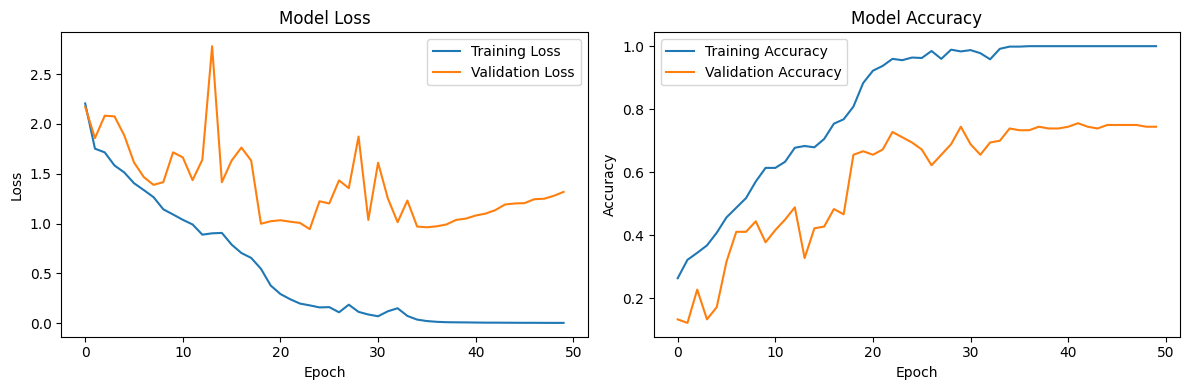

Evaluating model...
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 580ms/step
Test Accuracy: 0.7111

Classification Report:
                         precision    recall  f1-score   support

         Moon_jellyfish       0.77      0.84      0.81        32
       barrel_jellyfish       0.70      0.66      0.68        29
         blue_jellyfish       0.58      0.58      0.58        24
      compass_jellyfish       0.88      0.58      0.70        38
   lions_mane_jellyfish       0.69      0.83      0.75        29
mauve_stinger_jellyfish       0.65      0.79      0.71        28

               accuracy                           0.71       180
              macro avg       0.71      0.71      0.70       180
           weighted avg       0.73      0.71      0.71       180



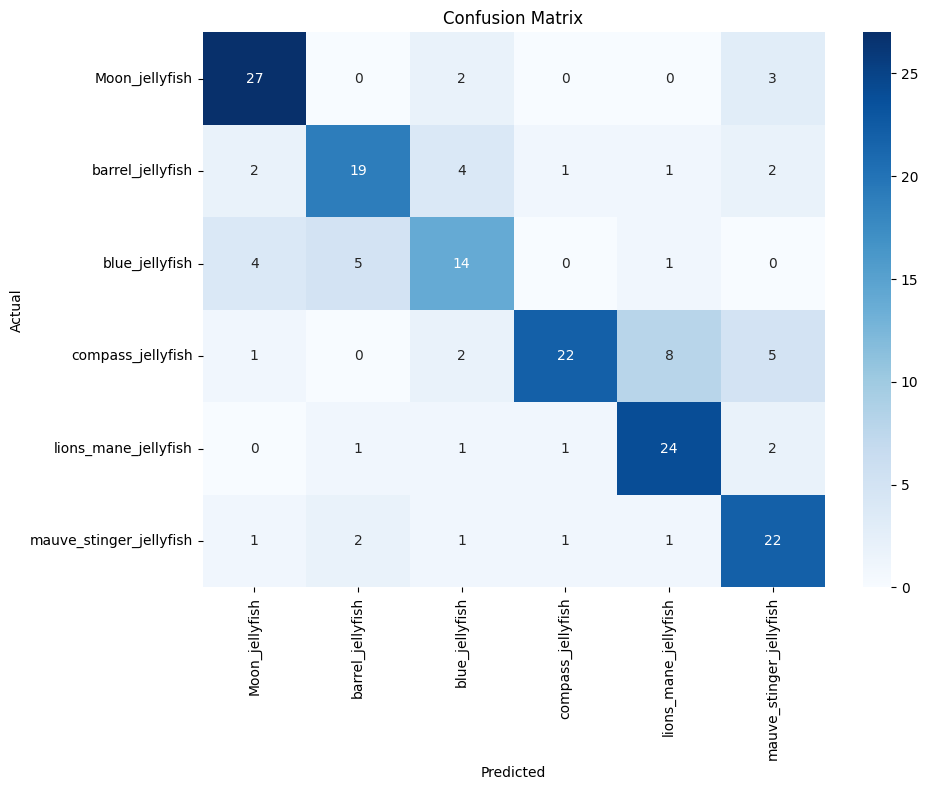

Training completed!


In [46]:
"""
main
"""

def main():
    """Main training pipeline"""
    print("Loading dataset...")

    # Check if dataset path exists
    if not os.path.exists(DATASET_PATH):
        print(f"Dataset path {DATASET_PATH} does not exist!")
        print("Please make sure your images are organized in subdirectories by class.")
        return

    # Create data generators directly
    try:
        train_dataset = keras.utils.image_dataset_from_directory(
            DATASET_PATH,
            validation_split=0.2,
            subset="training",
            seed=42,
            image_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            label_mode='int'
        )

        val_dataset = keras.utils.image_dataset_from_directory(
            DATASET_PATH,
            validation_split=0.2,
            subset="validation",
            seed=42,
            image_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            label_mode='int'
        )

        # Get class names
        class_names = train_dataset.class_names
        NUM_CLASSES = len(class_names)

        print(f"Found {NUM_CLASSES} classes: {class_names}")

    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Make sure your dataset directory contains subdirectories for each class.")
        return

    # Normalize data
    normalization_layer = layers.Rescaling(1./255)
    train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

    # Optimize performance
    AUTOTUNE = -1  # Use -1 for auto-tuning in Keras 3
    train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    # Create model
    print("Creating model...")
    try:
        model = create_coatnet_model(NUM_CLASSES, IMAGE_SIZE)
    except Exception as e:
        print(f"Error creating CoAtNet model: {e}")
        print("oops looks like you have a fatal error , call in the doctor")


    # Train model
    print("Starting training...")
    history = train_model(model, train_dataset, val_dataset, class_names)

    # Plot results
    plot_training_history(history)

    # Evaluate model
    print("Evaluating model...")
    accuracy, cm = evaluate_model(model, val_dataset, class_names)

    # Save metrics
    metrics_df = pd.DataFrame({
        'epoch': range(len(history.history['loss'])),
        'train_loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'train_accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy']
    })
    metrics_df.to_csv('training_metrics.csv', index=False)

    print("Training completed!")


if __name__ == "__main__":
    main()